In [1]:
# !pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

In [2]:
from matplotlib import pyplot as plt
import mediapipe as mp
import numpy as np
import time
import cv2
import os
import seaborn as sns
import pandas as pd

### Mediapipe object and utils

- In this part, we first the functions necessary for the data collection and detection. 

**mp.solutions.holistic** - MediaPipe Holistic utilizes the pose, face and hand landmark models in MediaPipe Pose, MediaPipe Face Mesh and MediaPipe Hands respectively to generate a total of 543 landmarks (33 pose landmarks, 468 face landmarks, and 21 hand landmarks per hand).

**mp.solutions.drawing_utils** - utils used for drawing the keypoints on the image/frame.

> FUNCTIONS:
- **detect_mpLeypoints()** - this function will change the image from BGR to RGB as well as setting it to non-rewritable before detecting keypoints in the frame using mediapipe.
- **custom_keypoints()** - it customizes the design of your keypoints in the frame.
- **get_keypoints()** - it extracts the array values of each keypoint's x,y, and z attributes to a 1-dimensional array.

In [3]:
mp_holistic = mp.solutions.holistic 
mp_drawing = mp.solutions.drawing_utils 

In [4]:
def detect_mpKeypoints(image, model):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image) # Make detection - hand landmarks
   
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    
    return image, results
    

In [5]:
#CUSTOMIZED LANDMARK DRAWINGS
#BGR channels are used here
def custom_keypoints(image, results):

    #left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(228,66,184), thickness=2, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(224,205,255), thickness=2, circle_radius=2)
                             ) 
    #right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                              mp_drawing.DrawingSpec(color=(228,66,184), thickness=2, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(224,205,255), thickness=2, circle_radius=2)
                             ) 

In [6]:
def get_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

### COLLECTING DATASETS
- In collecting datasets, we set 30 folders for each class/category with 30 numpy values inside. Each class/category will have 900 numpy values. All in all, we will have 2,700 dataset values for A,B, and C categories.

In [29]:
# Path for exported data, numpy arrays
DNN_PATH = os.path.join('FSL_ALPHABETS_KEYPOINTS') 

# Actions that we try to detect
# J is dynamic thooo
# ['a', 'b', 'c', 'd','e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u','v','w', 'x', 'y']
action_labels = np.array(['o', 'p', 'q']) # 
no_sequence = 80
sequence_length = 60

In [30]:
DNN_PATH = os.path.join('FSL_ALPHABETS_KEYPOINTS') 
for action in action_labels: 
    for sequence in range(60, no_sequence):
        try: 
            os.makedirs(os.path.join(DNN_PATH, action, str(sequence)))
            os.makedirs(os.path.join(DNN_PATH, action, str(sequence)))
        except:
            pass

In [31]:
cap = cv2.VideoCapture(0 + cv2.CAP_DSHOW)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    for action in action_labels:
        for sequence in range(60, no_sequence):
            for frame_num in range(sequence_length):

                ret, frame = cap.read()
                
                if not ret:
                    continue
                
                img_name = os.path.join(DNN_PATH, action, str(sequence), "{}.png".format(frame_num))
                cv2.imwrite(img_name, frame)
                
                image, results = detect_mpKeypoints(frame, holistic)
                custom_keypoints(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,247), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 216), 1, cv2.LINE_AA)
                    cv2.imshow('FSL DATASET COLLECTION', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 216), 1, cv2.LINE_AA)
                    cv2.imshow('FSL DATASET COLLECTION', image)
                
                keypoints = get_keypoints(results)
                npy_path = os.path.join(DNN_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [11]:
cap.read()

(False, None)

In [12]:
cap.release()
cv2.destroyAllWindows()

### Training and Testing collected data

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
label_map = {label:num for num, label in enumerate(action_labels)}

In [9]:
frames = []
frame_label = []
for action in action_labels:
    for sequence in range(no_sequence):
        for frame_num in range(sequence_length):
            frame_path = os.path.join(DNN_PATH, action, str(sequence), "{}.npy".format(frame_num))
            res = np.load(frame_path)
            res = res.astype(np.float)
            
            if set(res) == {0.0}:
                print(f"{frame_path}")
                # print('RES: ', res, '\n LENGTH: ', len(res))
                # os.remove(frame_path)
            else:
                pass
                # print('NOT ZEROES')
                
            frames.append(res)
            frame_label.append(label_map[action])

C:\Users\Admin\AppData\Local\Temp\ipykernel_10960\3166993497.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  res = res.astype(np.float)


FSL_ALPHABETS_KEYPOINTS\h\0\0.npy
FSL_ALPHABETS_KEYPOINTS\h\31\2.npy


In [10]:
len(frames)

86400

In [11]:
len(frames[1])

126

In [12]:
len(frame_label)

86400

In [13]:
frames[1]

array([ 9.12144661e-01,  6.44526362e-01, -5.59796320e-07,  8.65454733e-01,
        6.09740436e-01, -2.08053757e-02,  8.34837854e-01,  5.30399323e-01,
       -2.45864410e-02,  8.24566782e-01,  4.64975744e-01, -2.66236905e-02,
        8.18369985e-01,  4.11457717e-01, -2.46222448e-02,  8.55283737e-01,
        4.60522562e-01, -2.76049390e-03,  8.66879880e-01,  4.68473852e-01,
       -2.44642477e-02,  8.78510058e-01,  5.26228786e-01, -3.70899849e-02,
        8.82470131e-01,  5.66887558e-01, -4.11869250e-02,  8.90642822e-01,
        4.50598717e-01,  5.74091973e-04,  9.02116835e-01,  4.72224504e-01,
       -2.16285381e-02,  9.04849470e-01,  5.36728263e-01, -2.82166451e-02,
        9.02634144e-01,  5.76539814e-01, -2.65108664e-02,  9.24460590e-01,
        4.56675082e-01, -5.44517068e-04,  9.33976948e-01,  4.75877643e-01,
       -2.52241772e-02,  9.28360760e-01,  5.36470950e-01, -2.14124322e-02,
        9.20973122e-01,  5.73143601e-01, -1.13032125e-02,  9.55353916e-01,
        4.71559793e-01, -

## Cleaning Data: Removing zero values

In [14]:
print(len(frames))
print(len(frame_label))

86400
86400


In [15]:
X = np.array(frames)

In [16]:
labels = np.array(frame_label)

In [17]:
y = to_categorical(frame_label).astype(int) #converted to one-hot-encoding

In [18]:
X.shape 

(86400, 126)

In [19]:
y.shape

(86400, 24)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08)

### Building DNN Model
- For our model, we just chose a simple DNN which is the Dense layer, and 1 dropout layer to help the model avoid overfitting. Our activation for the input layer and hidden layer are ReLU and for the output layer is softmax, since we have categorical data.

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import TensorBoard 

In [22]:
# %load_ext tensorboard
# %tensorboard --logdir="log_dir" --port=9999

log_dir = os.path.join('FSL_ALPHABET_LOGS9')
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True, update_freq="epoch")

In [23]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=126))
model.add(Dense(36, activation='relu', input_dim=126))
# model.add(Dense(72, activation='relu', input_dim=126))
model.add(Dense(128, activation='relu', input_dim=126))
model.add(Dense(256, activation='relu', input_dim=126))
model.add(Dropout(0.5))
model.add(Dense(2, activation='relu', input_dim=126))
model.add(Dense(21, activation='relu', input_dim=126))
model.add(Dense(action_labels.shape[0], activation='softmax')) 

In [24]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['mse','categorical_accuracy', 'accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=1900, callbacks=[tb_callback])

Epoch 1/1900
2484/2484 [==============================] - 13s 4ms/step - loss: 2.3597 - mse: 0.0361 - categorical_accuracy: 0.1864 - accuracy: 0.1864
Epoch 2/1900
2484/2484 [==============================] - 10s 4ms/step - loss: 1.0568 - mse: 0.0220 - categorical_accuracy: 0.6105 - accuracy: 0.6105
Epoch 3/1900
2484/2484 [==============================] - 10s 4ms/step - loss: 0.5522 - mse: 0.0124 - categorical_accuracy: 0.7798 - accuracy: 0.7798
Epoch 4/1900
2484/2484 [==============================] - 10s 4ms/step - loss: 0.3682 - mse: 0.0082 - categorical_accuracy: 0.8611 - accuracy: 0.8611
Epoch 5/1900
2484/2484 [==============================] - 10s 4ms/step - loss: 0.2719 - mse: 0.0058 - categorical_accuracy: 0.9021 - accuracy: 0.9021
Epoch 6/1900
2484/2484 [==============================] - 10s 4ms/step - loss: 0.1963 - mse: 0.0042 - categorical_accuracy: 0.9303 - accuracy: 0.9303
Epoch 7/1900
2484/2484 [==============================] - 10s 4ms/step - loss: 0.1747 - mse: 0.0037 

### Model Evaluation and Prediction

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                8128      
                                                                 
 dense_1 (Dense)             (None, 36)                2340      
                                                                 
 dense_2 (Dense)             (None, 128)               4736      
                                                                 
 dense_3 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 514       
                                                                 
 dense_5 (Dense)             (None, 21)                6

In [28]:
res = model.predict(X_test)

216/216 [==============================] - 1s 3ms/step


In [29]:
print(res)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 9.2615772e-32]
 [0.0000000e+00 9.2678987e-34 2.1656656e-38 ... 1.0232855e-36
  2.3248172e-26 0.0000000e+00]
 [0.0000000e+00 6.7789374e-21 4.4236772e-28 ... 2.9966224e-15
  0.0000000e+00 3.1890263e-36]
 ...
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.7753713e-04 0.0000000e+00 ... 9.9975473e-01
  0.0000000e+00 0.0000000e+00]]


In [30]:
X_test.shape

(6912, 126)

In [31]:
res.shape

(6912, 24)

In [32]:
action_labels[np.argmax(res[11])]

'i'

In [33]:
action_labels[np.argmax(y_test[11])]

'i'

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [35]:
yhat = model.predict(X_test)

216/216 [==============================] - 1s 3ms/step


In [36]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [37]:
fsl_matrix =confusion_matrix(ytrue, yhat)

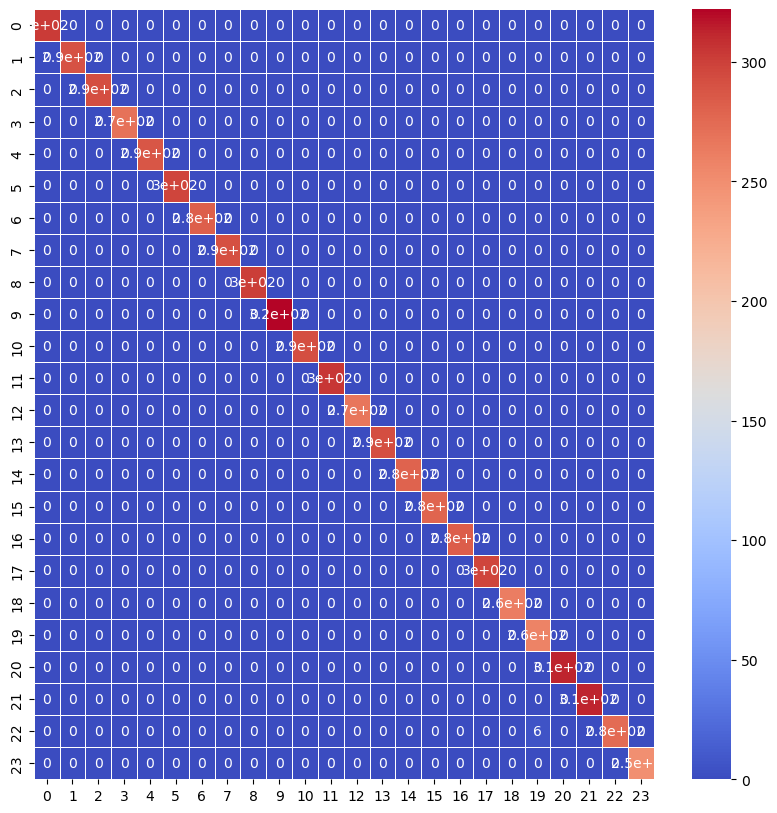

In [38]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(fsl_matrix, annot=True, linewidths=.5, ax=ax,  cmap='coolwarm')

# plt.figure(figsize=(30, 10))
# plt.title('FSL CONFUSION MATRIX RESULT', )
plt.show()

In [39]:
accuracy_score(ytrue, yhat)

0.9991319444444444

## CONVERSION OF MODEL TO TFLITE

In [40]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('fsl_alphabet_model9.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp8qmc7ix_\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp8qmc7ix_\assets


In [41]:
fsl_report = classification_report(ytrue, yhat, target_names=action_labels,output_dict=True)

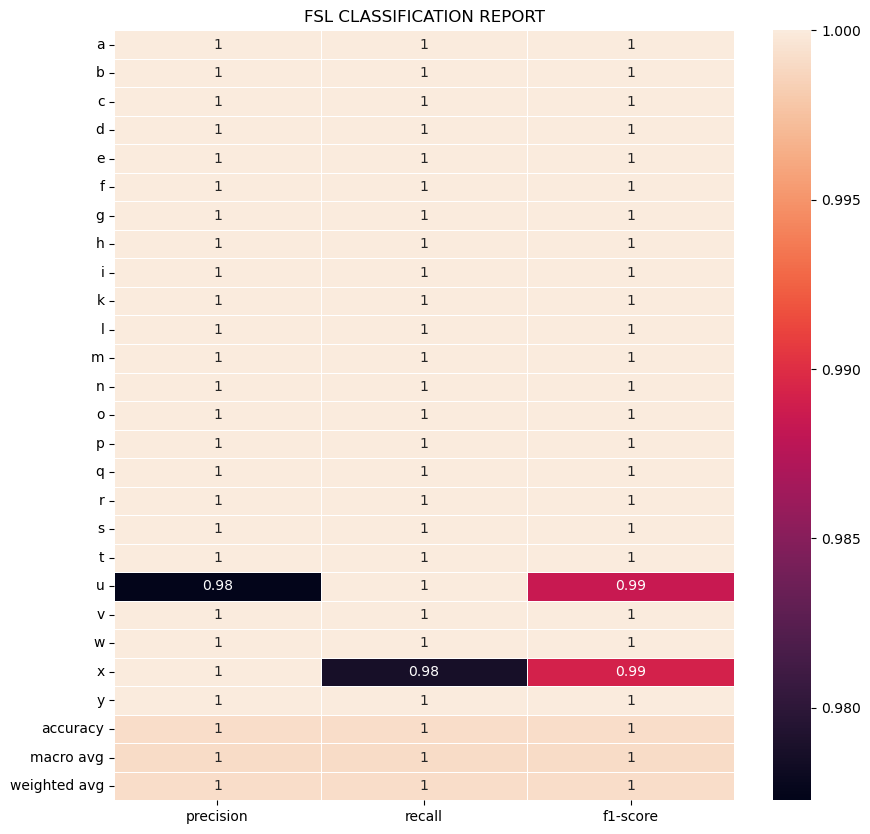

In [42]:
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(pd.DataFrame(fsl_report).iloc[:-1, :].T, annot=True, linewidths=.5, ax=ax)
plt.title('FSL CLASSIFICATION REPORT', )
plt.show()

In [43]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("FSL_MODEL.json", "w") as json_file:
#     json_file.write(model_json)
    
# # serialize weights to HDF5
# model.save_weights("FSL_MODEL.h5")
# print("Saved model to disk")

In [44]:
weights_list = model.get_weights()
# weights_list

In [45]:
len(weights_list)

14

In [46]:
print(action_labels)

['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's'
 't' 'u' 'v' 'w' 'x' 'y']


### Real-time Prediction Testing

In [51]:
threshold = 0.999
cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():


        ret, frame = cap.read()
        image, results = detect_mpKeypoints(frame, holistic)
       
        custom_keypoints(image, results)         
        keypoints = get_keypoints(results)

        if np.argmax(keypoints) == 0:
            pass
        else:
            res = model.predict(np.expand_dims(keypoints, axis=0))
            if np.amax(res) > threshold:
                print('PREDICTIONS: ',np.amax(res), "  |  ALL: ",res)
                print("SIGN: ", action_labels[np.argmax(res)])
            else:
                print('PLEASE TRY AGAIN')
                print('PREDICTIONS: ',res)

        cv2.imshow('FSL RECOGNITION', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
            
    cap.release()
    cv2.destroyAllWindows()

In [170]:
cap.release()
cv2.destroyAllWindows()